In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,8)}, palette='deep')
%matplotlib inline

In [128]:
data = pd.read_csv("Bengaluru_House_Data.csv")
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [129]:
#availability has lots of dates which are not in context, so its better to drop it
data2 = data.drop(columns=['society', 'balcony', 'availability'])
data2.dropna(inplace=True)

In [130]:
data2.head()

,area_type,location,size,total_sqft,bath,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,62.00
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,51.00


In [131]:
data2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [132]:
#Collecting the first split from size attribute values
data2['bhk'] = data2['size'].apply(lambda x: float(x.split()[0]))
data2.drop(columns=['size'], inplace=True)

In [133]:
def is_float(x):
    '''
    To check for float values
    '''
    try:
        float(x)
    except:
        return False
    return True

def make_float(x):
    '''
    To take average of two values if they are stored as a range
    Or else float the value is its a number otherwise return None
    '''
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [134]:
data2['total_sqft'] = data2['total_sqft'].apply(make_float)

In [135]:
#Feature Engineering
data2['per_sqft'] = data2['price']*100000/data2['total_sqft']

#Checking for number of entries by location
loc_agg = data2.groupby('location')['location'].agg('count').sort_values(ascending=False)
loc_agg_other = loc_agg[loc_agg <= 10]

#Locations with less than 10 entries will be stored as "other"
data2['location'] = data2['location'].apply(lambda x: 'other' if x in loc_agg_other else x)

In [136]:
#Outlier detection and removal

#Sqft area per bedroom is usually higher than 300
#So removing values with per room sqft area less than 300
data3 = data2[~(data2.total_sqft/data2.bhk<300)]

data3.per_sqft.describe()
#The min value for price of per_sqft area is 277 which is very unlikely
#Similarly the max value for price per_sqft area is 1,76,470 which is absurdly high

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: per_sqft, dtype: float64

In [137]:
#Removing outliers per location
def rem_outliers_by_loc(df):
    '''
    Retaining 68% of data and removing upper and lower extremes (outliers) by location
    Basically, reducing the dataframe between (mean - 1 std) and (mean + 1 std)
    '''
    out_df = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        mean = np.mean(subdf.per_sqft)
        std = np.std(subdf.per_sqft)
        reduced_df = subdf[(subdf.per_sqft > (mean-std)) & (subdf.per_sqft < (mean+std))]
        out_df = pd.concat([out_df, reduced_df], ignore_index=True)
    return out_df

In [138]:
data3 = rem_outliers_by_loc(data3)

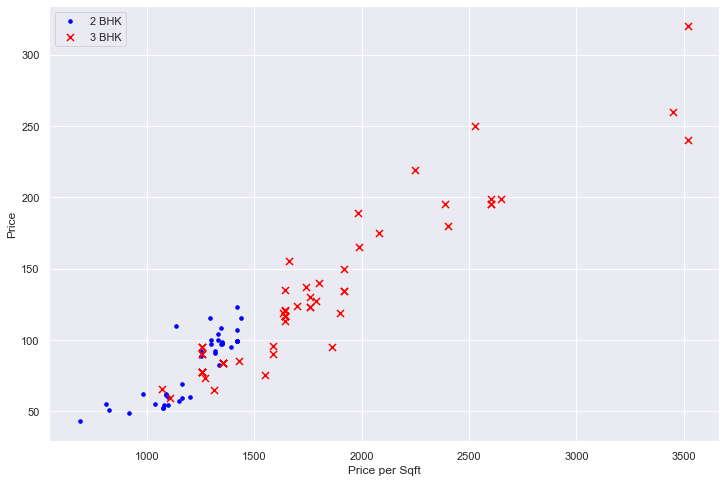

In [139]:
#Now apartments in the same location with Higher number of rooms are expected have higher prices
#But for some apartments in the same location higher BHK apartments have price_per_sqft less than lower BHK apartments
#Let's remove such outliers for fair estimation of prices

#Plot function to visualize such outliers
def plot_bhk_outliers(df, location):
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    plt.rcParams['figure.figsize'] = (12,8)
    plt.scatter(bhk2.total_sqft, bhk2.price, marker=".", color='blue', label='2 BHK',s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='x', color='red', label='3 BHK', s=50)
    plt.xlabel('Price per Sqft')
    plt.ylabel('Price')
    plt.legend()

plot_bhk_outliers(data3, 'Hebbal')

In [140]:
def rem_bhk_outliers(df):
    rem_indices = np.array([])
    
    for location, loc_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in loc_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.per_sqft),
                'std': np.std(bhk_df.per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in loc_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                rem_indices = np.append(rem_indices, bhk_df[bhk_df.per_sqft < stats['mean']].index.values)
    return df.drop(rem_indices, axis='index')

In [141]:
final_df = rem_bhk_outliers(data3)

In [142]:
final_df.head()

,area_type,location,total_sqft,bath,price,bhk,per_sqft
1,Super built-up Area,Devarachikkanahalli,1250.0,2.0,40.0,2.0,3200.000000
2,Plot Area,Devarachikkanahalli,1200.0,2.0,83.0,2.0,6916.666667
3,Super built-up Area,Devarachikkanahalli,1170.0,2.0,40.0,2.0,3418.803419
4,Super built-up Area,Devarachikkanahalli,1425.0,2.0,65.0,3.0,4561.403509
5,Super built-up Area,Devarachikkanahalli,947.0,2.0,43.0,2.0,4540.654699


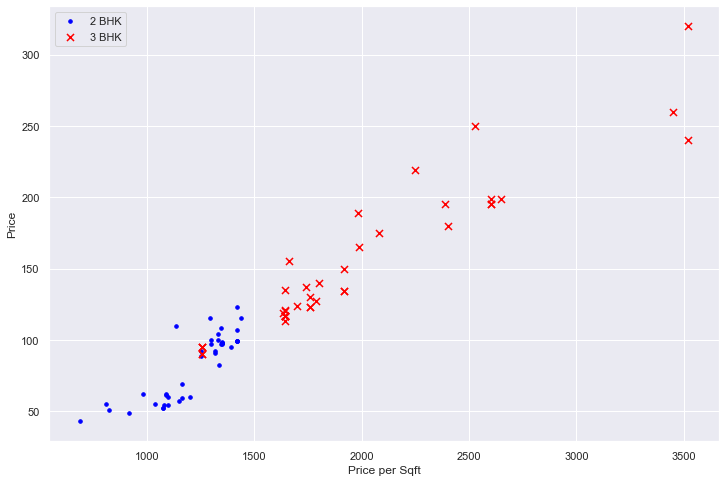

In [143]:
plot_bhk_outliers(final_df, 'Hebbal')

In [144]:
#Removing apartments with no.of bathrooms greater than no.of bedrooms+2
final_df = final_df[final_df.bath < final_df.bhk + 2]

In [145]:
#Dropping per_sqft feature which was only useful for outlier detection
final_df.drop(columns=['per_sqft'], inplace=True)
final_df.head()

,area_type,location,total_sqft,bath,price,bhk
1,Super built-up Area,Devarachikkanahalli,1250.0,2.0,40.0,2.0
2,Plot Area,Devarachikkanahalli,1200.0,2.0,83.0,2.0
3,Super built-up Area,Devarachikkanahalli,1170.0,2.0,40.0,2.0
4,Super built-up Area,Devarachikkanahalli,1425.0,2.0,65.0,3.0
5,Super built-up Area,Devarachikkanahalli,947.0,2.0,43.0,2.0


In [146]:
#One hot encoding "location" feature
loc_dummies = pd.get_dummies(final_df.location)

final_df = pd.concat([final_df, loc_dummies.drop(columns=['other'])], axis=1)

In [147]:
final_df.drop(columns=['area_type', 'location'], inplace=True)

In [150]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [151]:
X = final_df.drop(columns=['price'])
y = final_df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [152]:
model = LinearRegression()

In [153]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8200023784333137

In [154]:
#Cross-Validation
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.2)
cross_val_score(LinearRegression(),X,y, cv=cv)

array([0.87208235, 0.86908651, 0.85849446, 0.88532701, 0.81420825])

In [155]:
#Hyper-parameter Optimization using GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

def spit_best_model(X,y):
    models = {
        'linear_regression':{
            'model':LinearRegression(),
            'params': {
                'normalize':[True, False]
            }
        },
        'lasso':{
            'model':Lasso(),
            'params':{
                'alpha':[1,2],
                'selection':['random', 'cyclic']
            }
        },
        'dtree':{
            'model':DecisionTreeRegressor(),
            'params':{
                'criterion':['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=4)
    for model_name,config in models.items():
        grid = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        grid.fit(X,y)
        scores.append({
            'model': model_name,
            'best_score': grid.best_score_,
            'best_params': grid.best_params_
        })
        print(f'Model tuning for {model_name} completed successfully!')
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [156]:
spit_best_model(X,y)

Model tuning for linear_regression completed successfully!
Model tuning for lasso completed successfully!
Model tuning for dtree completed successfully!


,model,best_score,best_params
0,linear_regression,0.863176,{'normalize': False}
1,lasso,0.726380,"{'alpha': 1, 'selection': 'cyclic'}"
2,dtree,0.747909,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [171]:
def predict_price(sqft, bath, bhk, location):
    loc_idx = np.where(X.columns == location)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_idx >= 0:
        x[loc_idx] = 1
        
    return model.predict([x])[0]

In [181]:
predict_price(1000, 2, 2, 'Indira Nagar')

168.42384622798926

In [182]:
#Saving the model into a pickle file
import pickle
with open('Bengaluru_re_pred_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [184]:
#Saving col names in a json file
import json
columns = {
    'column_names': [col.lower() for col in X.columns]
}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))